In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from tqdm import tqdm

In [28]:
train = pd.read_csv('../../data/yelp/train_en.txt', sep='\t')
test = pd.read_csv('../../data/yelp/test_en.txt', sep='\t')
val = pd.read_csv('../../data/yelp/val_en.txt', sep='\t')

In [29]:
print(f"Train samples: {len(train)}")
print(f"Validation samples: {len(val)}")
print(f"Test samples: {len(test)}")

Train samples: 342905
Validation samples: 42863
Test samples: 42864


In [30]:
train.head()

,Sentence,Style,User
0,Cute interior and owner (?) gave us tour of up...,positive,bcjbaE6dDog4jkNY91ncLQ
1,I've been to this location many times when I l...,negative,enaHB1e956thdnafcHVAig
2,My food only merited maybe two stars but I wil...,negative,07aVWNhBhpwqW3MdqoKDKQ
3,After trying a few ramen places with crazy var...,negative,OkjeFppodgJP_CvB84cJYw
4,I cannot even believe someone gave this place ...,positive,7Ie0VmQtnGYUVq2YW4dTVw


In [45]:
labels_train = train['Style'].values
labels_val = val['Style'].values
labels_test = test['Style'].values

In [46]:
LE = LabelEncoder()
LE.fit(labels_train)

LabelEncoder()

In [47]:
y_train = LE.transform(labels_train)
y_val =  LE.transform(labels_val)
y_test = LE.transform(labels_test)
y_train

array([1, 0, 0, ..., 0, 1, 1], shape=(342905,))

In [34]:
print(f"Label distribution in train:\n{train['Style'].value_counts()}")

Label distribution in train:
Style
positive    246823
negative     96082
Name: count, dtype: int64


In [35]:
sentences = test['Sentence'].tolist()
true_labels = test['Style'].tolist()

##### T5

In [50]:
model_name_t5_base = "t5-base"
t5_tokenizer_base = AutoTokenizer.from_pretrained(model_name_t5_base)
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5_base)

In [51]:
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t5_model_base = t5_model_base.to(device1)

In [62]:
sample_text = test['Sentence'].values[2]
prompt = f"Classify this review as positive or negative: {sample_text}\nAnswer:"
print(f"Prompt: {prompt}")

Prompt: Classify this review as positive or negative: I stopped in because I was hungry for some snacks.  Browsed the store since I had some spare time and found it to be clean and well stocked.  Wide isles, good selection of bakery stuff, flowers and all your usual groceries. I like that they had some locally made snacks too like California Kettle Corn and Taco Works (out of SLO).  Found the semi-unusual chips I wanted that other stores don't always carry, grabbed a Diet Coke by the checkout and I was happy.  Convenient parking lot and the staff was friendly and helpful.  Thanks Albertsons!
Answer:


In [63]:
inputs = t5_tokenizer_base(prompt, return_tensors='pt')
inputs = {k: v.to(device1) for k, v in inputs.items()}

In [64]:
with torch.no_grad():
    output_ids = t5_model_base.generate(inputs['input_ids'], max_length=10)

In [65]:
prediction_b = t5_tokenizer_base.decode(output_ids[0], skip_special_tokens=True)
print(f"T5-base prediction: {prediction_b}")

T5-base prediction: I like that they had some local snacks


Continuing forward with instruction-tuned T5 model (Flan-T5)

##### (Flan) T5 - Zero-shot

In [36]:
model_name_t5 = "google/flan-t5-base"
t5_tokenizer = AutoTokenizer.from_pretrained(model_name_t5)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_name_t5)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t5_model = t5_model.to(device)

In [38]:
sample_text = test['Sentence'].values[2]
prompt = f"Classify this review as positive or negative: {sample_text}\nAnswer:"
print(f"Prompt: {prompt}")

Prompt: Classify this review as positive or negative: I stopped in because I was hungry for some snacks.  Browsed the store since I had some spare time and found it to be clean and well stocked.  Wide isles, good selection of bakery stuff, flowers and all your usual groceries. I like that they had some locally made snacks too like California Kettle Corn and Taco Works (out of SLO).  Found the semi-unusual chips I wanted that other stores don't always carry, grabbed a Diet Coke by the checkout and I was happy.  Convenient parking lot and the staff was friendly and helpful.  Thanks Albertsons!
Answer:


In [39]:
inputs = t5_tokenizer(prompt, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

In [40]:
with torch.no_grad():
    output_ids = t5_model.generate(inputs['input_ids'], max_length=10)

In [41]:
prediction = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"T5 prediction: {prediction}")

T5 prediction: positive


In [48]:
t5_zero_predictions = []

batch_size = 32
for i in tqdm(range(0, len(test), batch_size), desc="T5 Zero-shot"):
    batch_texts = test['Sentence'].values[i:i + batch_size]

    prompts = [f"Classify this review as positive or negative: {text}"
               for text in batch_texts]

    inputs = t5_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = t5_model.generate(inputs['input_ids'], max_length=10, num_beams=1)

    batch_preds = t5_tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    t5_zero_predictions.extend(batch_preds)

T5 Zero-shot: 100%|██████████| 1340/1340 [05:24<00:00,  4.13it/s]


In [66]:
print(f"Total predictions: {len(t5_zero_predictions)}")
print(f"Sample predictions: {t5_zero_predictions[:5]}")

Total predictions: 42864
Sample predictions: ['positive', 'negative', 'positive', 'negative', 'negative']


In [67]:
pred_t5_zero = []
for pred in t5_zero_predictions:
    pred_lower = pred.lower().strip()
    if 'positive' in pred_lower:
        pred_t5_zero.append(1)
    elif 'negative' in pred_lower:
        pred_t5_zero.append(0)
    else:
        pred_t5_zero.append(0)

In [68]:
pred_t5_zero = np.array(pred_t5_zero)

print(f'Accuracy: {accuracy_score(y_test, pred_t5_zero):.4f}')
print(f'Precision: {precision_score(y_test, pred_t5_zero):.4f}')
print(f'Recall: {recall_score(y_test, pred_t5_zero):.4f}')
print(f'F1-score: {f1_score(y_test, pred_t5_zero):.4f}')

Accuracy: 0.9091
Precision: 0.9053
Recall: 0.9757
F1-score: 0.9392


In [69]:
t5_zero_result = {
    'name': 'T5 Zero-shot',
    'accuracy': accuracy_score(y_test, pred_t5_zero),
    'precision': precision_score(y_test, pred_t5_zero),
    'recall': recall_score(y_test, pred_t5_zero),
    'f1': f1_score(y_test, pred_t5_zero)
}

##### (Flan) T5 - Few-shot

In [70]:
examples = """Text: The food was great and I loved the atmosphere.
Sentiment: positive

Text: The food was terrible and the service was slow.
Sentiment: negative

Text: Amazing experience, I would definitely come back.
Sentiment: positive

Text: Very disappointing, I will not return again.
Sentiment: negative
"""

In [71]:
sample_text = test['Sentence'].values[0]
few_shot_prompt = f"{examples}\nClassify this review as positive or negative:\nText: {sample_text}\nSentiment:"
print(few_shot_prompt)

Text: The food was great and I loved the atmosphere.
Sentiment: positive

Text: The food was terrible and the service was slow.
Sentiment: negative

Text: Amazing experience, I would definitely come back.
Sentiment: positive

Text: Very disappointing, I will not return again.
Sentiment: negative

Classify this review as positive or negative:
Text: The hubby and I have been here on multiple occasions and we have loved every part of the meal, every single time. Everyone from the servers to the bartender is very knowledgable about the menu and was able to immediately recommend items I could eat as-is, substitute or delete to make something safe for this Celiac girl to eat. The wine and cocktail menus are spot on. The food divine.  My only wish is that they would have a gluten-free dessert, we've always had to go elsewhere for something sweet. But that is not a big deal and I still want to go here time and time again.
Sentiment:


In [72]:
inputs = t5_tokenizer(few_shot_prompt, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

In [73]:
with torch.no_grad():
    output_ids = t5_model.generate(inputs['input_ids'], max_length=10)

In [74]:
prediction = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"T5 few-shot prediction: {prediction}")

T5 few-shot prediction: positive


In [75]:
t5_few_predictions = []

for i in tqdm(range(0, len(test), batch_size), desc="T5 Few-shot"):
    batch_texts = test['Sentence'].values[i:i + batch_size]

    prompts = [
        f"{examples}\nClassify this review as positive or negative:\nText: {text}\nSentiment:"
        for text in batch_texts]

    inputs = t5_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = t5_model.generate(inputs['input_ids'], max_length=10, num_beams=1)

    batch_preds = t5_tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    t5_few_predictions.extend(batch_preds)

T5 Few-shot: 100%|██████████| 1340/1340 [06:58<00:00,  3.20it/s]


In [76]:
pred_t5_few = []
for pred in t5_few_predictions:
    pred_lower = pred.lower().strip()
    if 'positive' in pred_lower:
        pred_t5_few.append(1)
    elif 'negative' in pred_lower:
        pred_t5_few.append(0)
    else:
        pred_t5_few.append(0)

pred_t5_few = np.array(pred_t5_few)

In [77]:
print(f'Accuracy: {accuracy_score(y_test, pred_t5_few):.4f}')
print(f'Precision: {precision_score(y_test, pred_t5_few):.4f}')
print(f'Recall: {recall_score(y_test, pred_t5_few):.4f}')
print(f'F1-score: {f1_score(y_test, pred_t5_few):.4f}')

Accuracy: 0.9107
Precision: 0.9112
Recall: 0.9705
F1-score: 0.9399


In [78]:
t5_few_result = {
    'name': 'T5 Few-shot',
    'accuracy': accuracy_score(y_test, pred_t5_few),
    'precision': precision_score(y_test, pred_t5_few),
    'recall': recall_score(y_test, pred_t5_few),
    'f1': f1_score(y_test, pred_t5_few)
}

##### BART

In [79]:
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')
bart_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')
bart_model = bart_model.to(device)

In [80]:
sample_text = test['Sentence'].values[0]
prompt = f"Summarize sentiment in one word (positive or negative): {sample_text}"
print(f"BART prompt: {prompt}")

BART prompt: Summarize sentiment in one word (positive or negative): The hubby and I have been here on multiple occasions and we have loved every part of the meal, every single time. Everyone from the servers to the bartender is very knowledgable about the menu and was able to immediately recommend items I could eat as-is, substitute or delete to make something safe for this Celiac girl to eat. The wine and cocktail menus are spot on. The food divine.  My only wish is that they would have a gluten-free dessert, we've always had to go elsewhere for something sweet. But that is not a big deal and I still want to go here time and time again.


In [81]:
inputs = bart_tokenizer(prompt, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

In [82]:
with torch.no_grad():
    output_ids = bart_model.generate(inputs['input_ids'], max_length=10)

In [83]:
prediction = bart_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"BART prediction: {prediction}")

BART prediction: Summarize sentiment in one word


BART-base is primarily made for sequence-to-sequence generation, and in this dataset it does not produce clear sentiment labels like we need. It is unsuitable for direct sentiment analysis without fine-tuning. To achieve good results, I will continue with zero-shot classification pipeline, BART-large-MNLI. (unsuitable for few-shot demonstrations)

##### BART-large-MNLI Zero-shot

In [98]:
bart_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    batch_size=16
)

Device set to use cuda


In [99]:
sample_text = test['Sentence'].values[0]
print(sample_text)

The hubby and I have been here on multiple occasions and we have loved every part of the meal, every single time. Everyone from the servers to the bartender is very knowledgable about the menu and was able to immediately recommend items I could eat as-is, substitute or delete to make something safe for this Celiac girl to eat. The wine and cocktail menus are spot on. The food divine.  My only wish is that they would have a gluten-free dessert, we've always had to go elsewhere for something sweet. But that is not a big deal and I still want to go here time and time again.


In [100]:
result = bart_classifier(sample_text, candidate_labels=["positive", "negative"])
result

{'sequence': "The hubby and I have been here on multiple occasions and we have loved every part of the meal, every single time. Everyone from the servers to the bartender is very knowledgable about the menu and was able to immediately recommend items I could eat as-is, substitute or delete to make something safe for this Celiac girl to eat. The wine and cocktail menus are spot on. The food divine.  My only wish is that they would have a gluten-free dessert, we've always had to go elsewhere for something sweet. But that is not a big deal and I still want to go here time and time again.",
 'labels': ['positive', 'negative'],
 'scores': [0.9335371851921082, 0.06646285951137543]}

In [101]:
print(f"BART-MNLI prediction: {result['labels'][0]}")
print(f"All scores:\npositive={result['scores'][0]:.4f}\nnegative={result['scores'][1]:.4f}")

BART-MNLI prediction: positive
All scores:
positive=0.9335
negative=0.0665


In [102]:
bart_zero_predictions = []

chunk_size = 64
for i in tqdm(range(0, len(test), chunk_size), desc="BART-MNLI Zero-shot"):
    chunk_texts = test['Sentence'].values[i:i+chunk_size].tolist()

    results = bart_classifier(chunk_texts, candidate_labels=["positive", "negative"])

    for result in results:
        bart_zero_predictions.append(result['labels'][0])

print(f"Total predictions: {len(bart_zero_predictions)}")
print(f"Sample BART-MNLI predictions: {bart_zero_predictions[:5]}")

BART-MNLI Zero-shot: 100%|██████████| 670/670 [22:14<00:00,  1.99s/it]

Total predictions: 42864
Sample BART-MNLI predictions: ['positive', 'negative', 'positive', 'negative', 'negative']


In [108]:
pred_bart_zero = []
for pred in bart_zero_predictions:
    pred_lower = pred.lower().strip()
    if 'positive' in pred_lower:
        pred_bart_zero.append(1)
    elif 'negative' in pred_lower:
        pred_bart_zero.append(0)
    else:
        pred_bart_zero.append(0)

In [109]:
pred_bart_zero = np.array(pred_bart_zero)

print(f'Accuracy: {accuracy_score(y_test, pred_bart_zero):.4f}')
print(f'Precision: {precision_score(y_test, pred_bart_zero):.4f}')
print(f'Recall: {recall_score(y_test, pred_bart_zero):.4f}')
print(f'F1-score: {f1_score(y_test, pred_bart_zero):.4f}')

Accuracy: 0.8626
Precision: 0.9116
Recall: 0.8960
F1-score: 0.9037


In [107]:
bart_zero_result = {
    'name': 'BART Zero-shot',
    'accuracy': accuracy_score(y_test, pred_bart_zero),
    'precision': precision_score(y_test, pred_bart_zero),
    'recall': recall_score(y_test, pred_bart_zero),
    'f1': f1_score(y_test, pred_bart_zero)
}

##### BART-base Few-shot

*BART-base attempt for few shot*

In [110]:
sample_text = test['Sentence'].values[0]
few_shot_prompt = f"{examples}\nClassify this review as positive or negative:\nText: {sample_text}\nSentiment:"
print(few_shot_prompt)

Text: The food was great and I loved the atmosphere.
Sentiment: positive

Text: The food was terrible and the service was slow.
Sentiment: negative

Text: Amazing experience, I would definitely come back.
Sentiment: positive

Text: Very disappointing, I will not return again.
Sentiment: negative

Classify this review as positive or negative:
Text: The hubby and I have been here on multiple occasions and we have loved every part of the meal, every single time. Everyone from the servers to the bartender is very knowledgable about the menu and was able to immediately recommend items I could eat as-is, substitute or delete to make something safe for this Celiac girl to eat. The wine and cocktail menus are spot on. The food divine.  My only wish is that they would have a gluten-free dessert, we've always had to go elsewhere for something sweet. But that is not a big deal and I still want to go here time and time again.
Sentiment:


In [111]:
inputs = bart_tokenizer(prompt, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

In [112]:
with torch.no_grad():
    output_ids = bart_model.generate(inputs['input_ids'], max_length=10)

In [113]:
prediction = bart_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"BART few-shot prediction: {prediction}")

BART few-shot prediction: Summarize sentiment in one word


In [115]:
bart_few_predictions = []

for i in tqdm(range(0, len(test), batch_size), desc="BART Few-shot"):
    batch_texts = test['Sentence'].values[i:i + batch_size]

    prompts = [f"{examples}\nClassify: {text}\nSentiment:" for text in batch_texts]

    inputs = bart_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = bart_model.generate(inputs['input_ids'], max_length=10, num_beams=1)

    batch_preds = bart_tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    bart_few_predictions.extend(batch_preds)

print(f"Sample BART few-shot predictions: {bart_few_predictions[:5]}")

BART Few-shot: 100%|██████████| 2679/2679 [06:34<00:00,  6.79it/s]

Sample BART few-shot predictions: ['Text: The food was great and', 'Text: The food was great and', 'Text: The food was great and', 'Text: The food was great and', 'Text: The food was great and']


In [116]:
pred_bart_few = []
for pred in bart_few_predictions:
    pred_lower = pred.lower().strip()
    if 'positive' in pred_lower:
        pred_bart_few.append(1)
    elif 'negative' in pred_lower:
        pred_bart_few.append(0)
    else:
        pred_bart_few.append(0)

In [117]:
pred_bart_few = np.array(pred_bart_few)

print(f'Accuracy: {accuracy_score(y_test, pred_bart_few):.4f}')
print(f'Precision: {precision_score(y_test, pred_bart_few):.4f}')
print(f'Recall: {recall_score(y_test, pred_bart_few):.4f}')
print(f'F1-score: {f1_score(y_test, pred_bart_few):.4f}')

Accuracy: 0.2802
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [118]:
bart_few_result = {
    'name': 'BART Few-shot',
    'accuracy': accuracy_score(y_test, pred_bart_few),
    'precision': precision_score(y_test, pred_bart_few),
    'recall': recall_score(y_test, pred_bart_few),
    'f1': f1_score(y_test, pred_bart_few)
}

C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


This model doesn’t understand few-shot prompts, just like it doesn’t handle zero-shot prompts properly, so it doesn’t give real "positive" or "negative" answers. Because of that, most of the predictions are wrong and the scores turn out very low.

In [119]:
results = [t5_zero_result, t5_few_result, bart_zero_result, bart_few_result]

results_df = pd.DataFrame([
    {
        'Model': r['name'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}"
    }
    for r in results
])

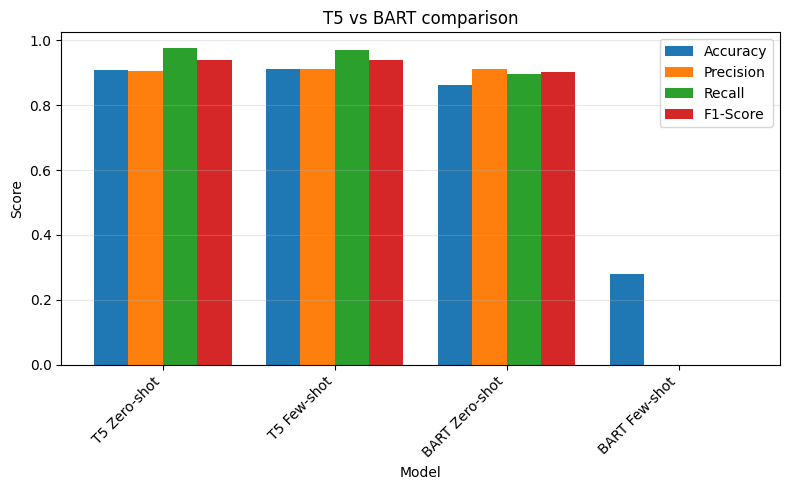

TOP MODEL (T5 vs BART):
Model: T5 Few-shot
Accuracy: 0.9107
Precision: 0.9112
Recall: 0.9705
F1-Score: 0.9399


In [140]:
t5_bart_names = [r['name'] for r in results]
accuracies = [r['accuracy'] for r in results]
precisions = [r['precision'] for r in results]
recalls = [r['recall'] for r in results]
f1s = [r['f1'] for r in results]

x = np.arange(len(t5_bart_names))
width = 0.2

plt.figure(figsize=(8,5))
plt.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5 * width, precisions, width, label='Precision')
plt.bar(x + 0.5 * width, recalls, width, label='Recall')
plt.bar(x + 1.5 * width, f1s, width, label='F1-Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('T5 vs BART comparison')
plt.xticks(x, t5_bart_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

best_model = max(results, key=lambda x: x['f1'])

print("TOP MODEL (T5 vs BART):")
print(f"Model: {best_model['name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1-Score: {best_model['f1']:.4f}")

In [128]:
lstm_result = {
    'name': 'LSTM_best',
    'accuracy': 0.9001,
    'precision': 0.9050,
    'recall': 0.9623,
    'f1': 0.9328
}

roberta_result = {
    'name': 'RoBERTa_best',
    'accuracy': 0.9220,
    'precision': 0.9357,
    'recall': 0.9575,
    'f1': 0.9464
}

distilbert_result = {
    'name': 'DistilBERT_best',
    'accuracy': 0.9126,
    'precision': 0.9286,
    'recall': 0.9518,
    'f1': 0.9401
}

In [129]:
all_results = [lstm_result, roberta_result, distilbert_result] + results

all_results_df = pd.DataFrame([
    {
        'Model': r['name'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}"
    }
    for r in all_results
])

COMPLETE COMPARISON:
          Model Accuracy Precision Recall F1-Score
      LSTM_best   0.9001    0.9050 0.9623   0.9328
   RoBERTa_best   0.9220    0.9357 0.9575   0.9464
DistilBERT_best   0.9126    0.9286 0.9518   0.9401
   T5 Zero-shot   0.9091    0.9053 0.9757   0.9392
    T5 Few-shot   0.9107    0.9112 0.9705   0.9399
 BART Zero-shot   0.8626    0.9116 0.8960   0.9037
  BART Few-shot   0.2802    0.0000 0.0000   0.0000


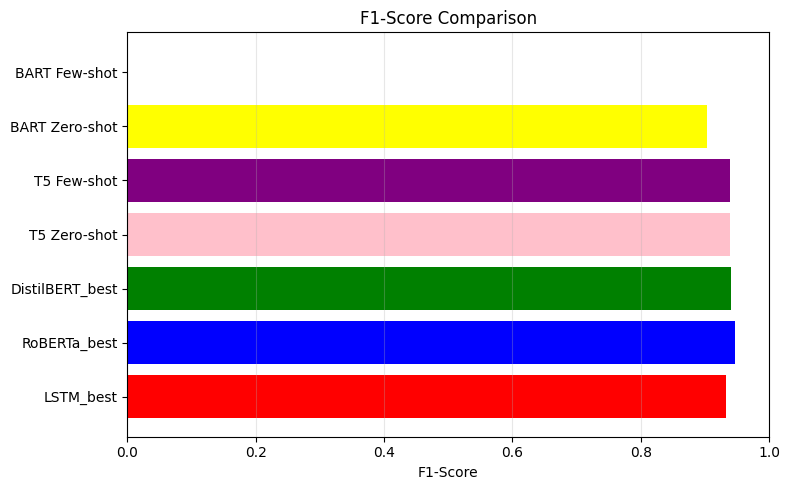

TOP MODEL
Model: RoBERTa_best
Accuracy: 0.9220
Precision: 0.9357
Recall: 0.9575
F1-Score: 0.9464


In [139]:
print("COMPLETE COMPARISON:")
print(all_results_df.to_string(index=False))

plt.figure(figsize=(8,5))
models = [r['name'] for r in all_results]
f1_scores = [r['f1'] for r in all_results]

plt.barh(models, f1_scores, color=['red', 'blue', 'green', 'pink', 'purple', 'yellow', 'darkgreen'])
plt.xlabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xlim([0, 1.0])
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

best_model = max(all_results, key=lambda x: x['f1'])

print("TOP MODEL")
print(f"Model: {best_model['name']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1-Score: {best_model['f1']:.4f}")

##### Conclusion:

The results showed that the supervised transformer models (RoBERTa and DistilBERT) again achieved the best scores, with RoBERTa having the highest F1-score overall. Both zero-shot and few-shot T5 models (FLAN-T5) perform surprisingly close to the fine-tuned baselines, showing that instruction-tuned T5 models generalize well even without the long specific training. BART in zero-shot (BART-large-MNLI) mode performs well but below the T5 models, while BART-base in a generative few-shot completely fails to produce usable labels, resulting in very low scores. Overall, the supervised transformers remain the most reliable choice, while zero/few-shot T5 offers great results, and generative BART prompts are not suitable for this sentiment task without fine-tuning.